# Ansatz

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import os

import re

# import data class
from utilities.dataset_utils import DiabetesData

from qiskit_machine_learning.algorithms import VQC

from qiskit import QuantumCircuit

# explainability imports
# feature map SHAP
from shap import KernelExplainer
from shap import Explanation
from shap.plots import waterfall

# state fidelity
from qiskit.quantum_info import state_fidelity

# qiskit imports
# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

In [3]:
# for reproducibility
np.random.seed(42)

Dataset loading - change code hear to analyze different dataset

**N.B.** works only for binary classification datasets

In [ ]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/barra-white/college/qml-explainability-by-parts/explainability/vqc/ansatz/../../utilities/diabetes.csv'

In [ ]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'models', 'qml-simulator', 'vqc_best_params.model')

vqc = VQC.load(path)

In [ ]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

In [ ]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [ ]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [ ]:
# sampler
sampler = Sampler.from_backend(backend)

### Ansatz Explainability

Below are helper functions to define an output required by SHAP. This output will serve as the prediction fed into SHAP's KernelExplainer

Ansatz implementation - change here to analyze different ansatz

In [ ]:
# generate feature map to fix to a training sample
feature_map = vqc.feature_map

In [ ]:
# generate ansatz used
ansatz = vqc.ansatz

In [ ]:
print(ansatz.name)
print(ansatz.num_qubits)

RealAmplitudes
8


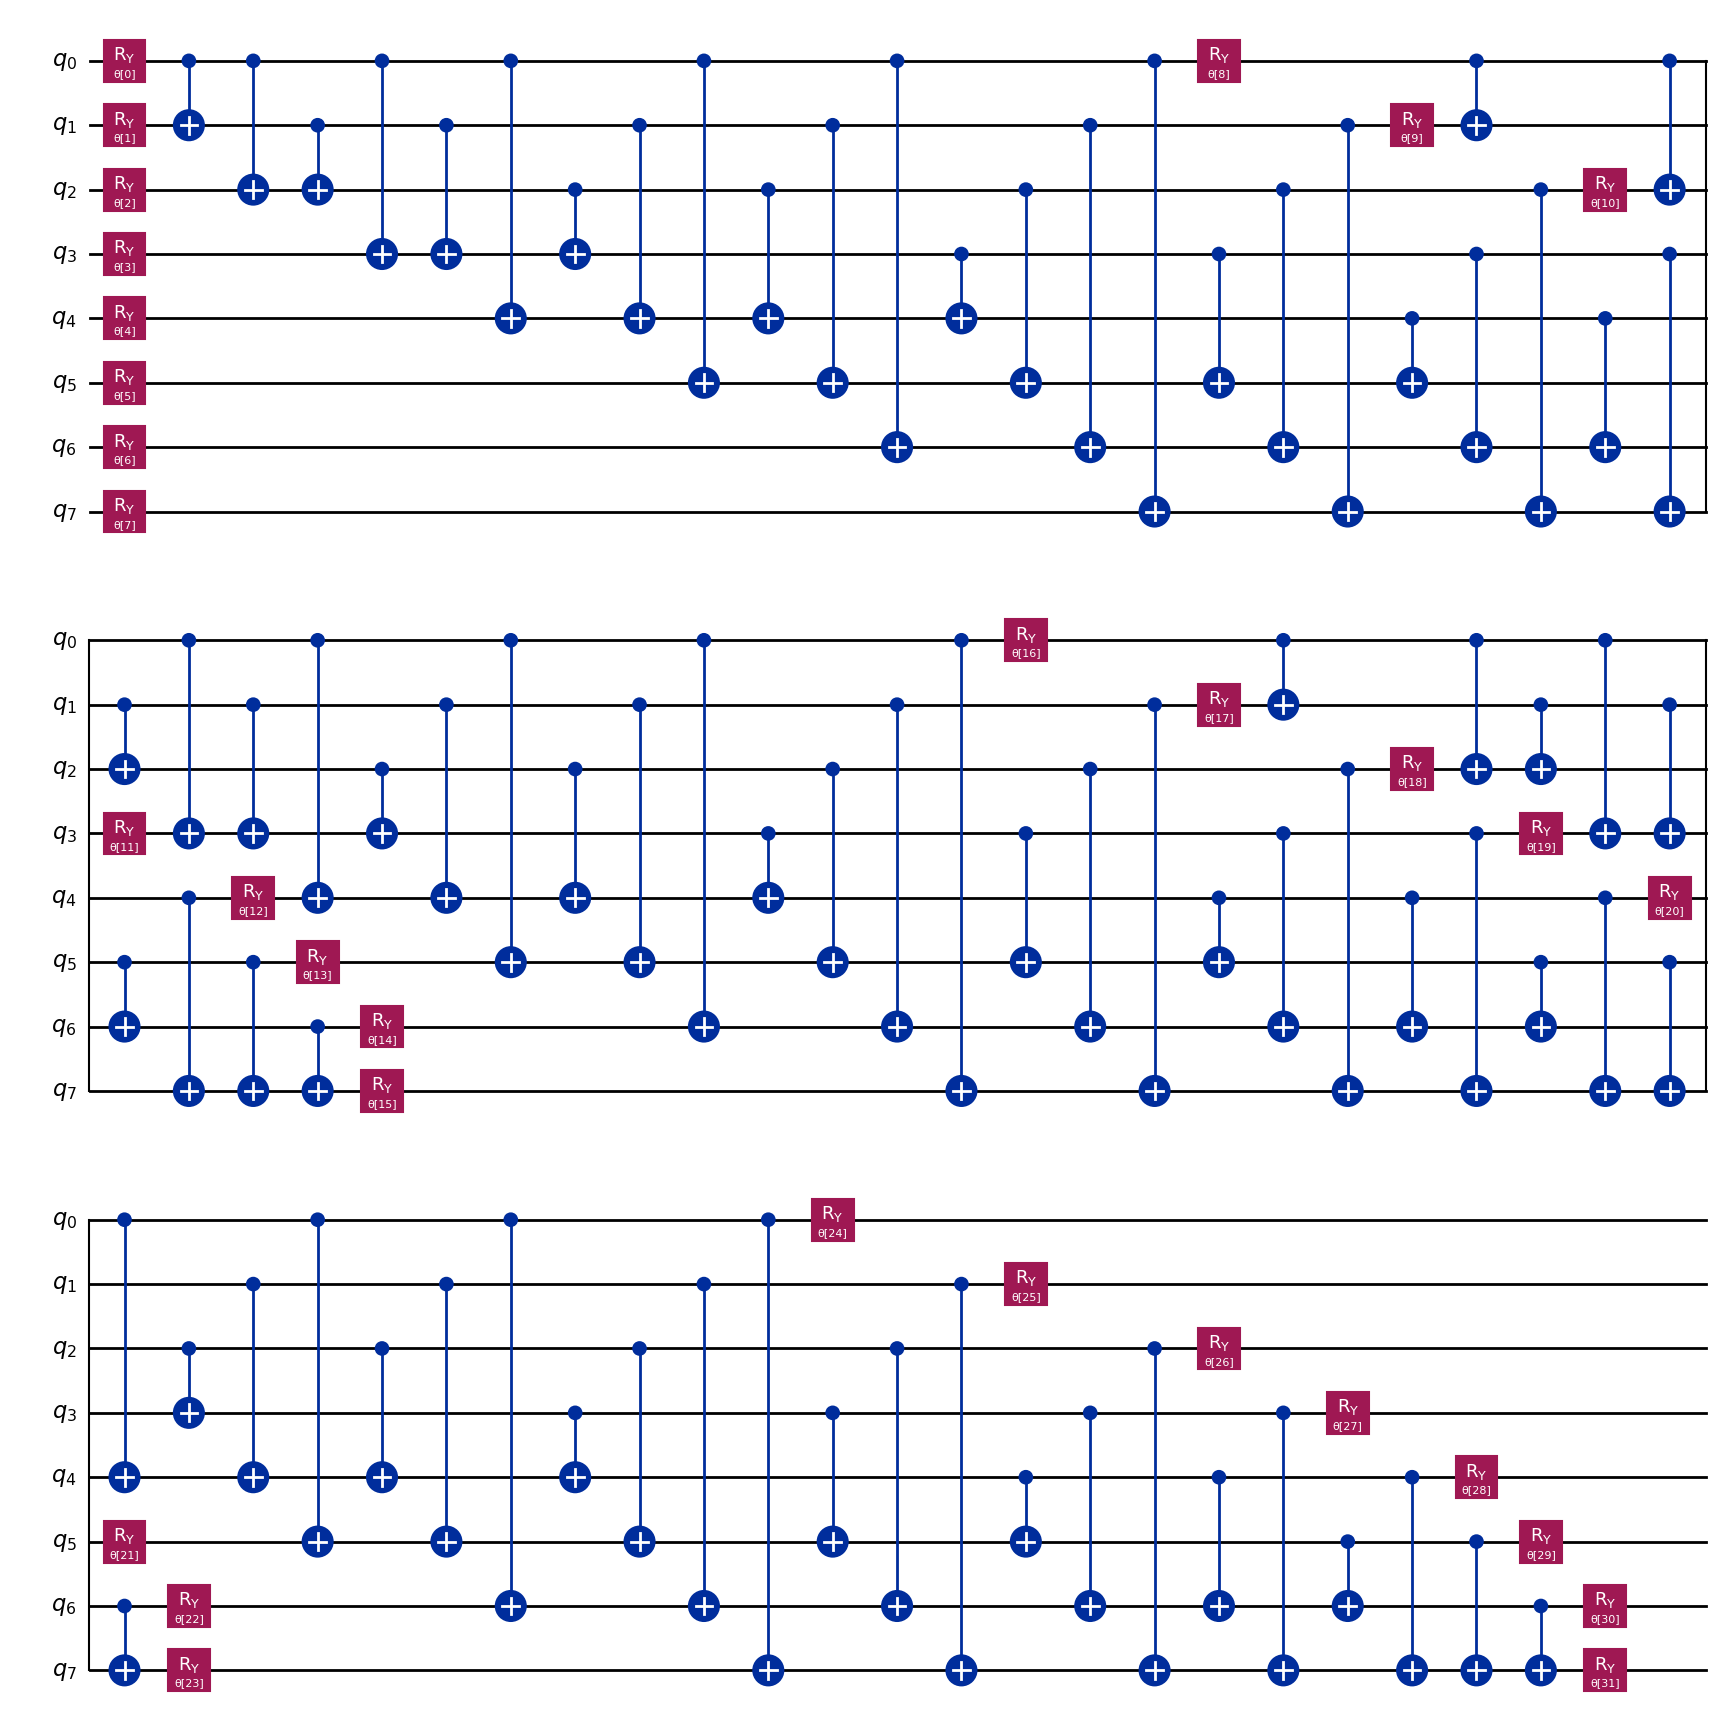

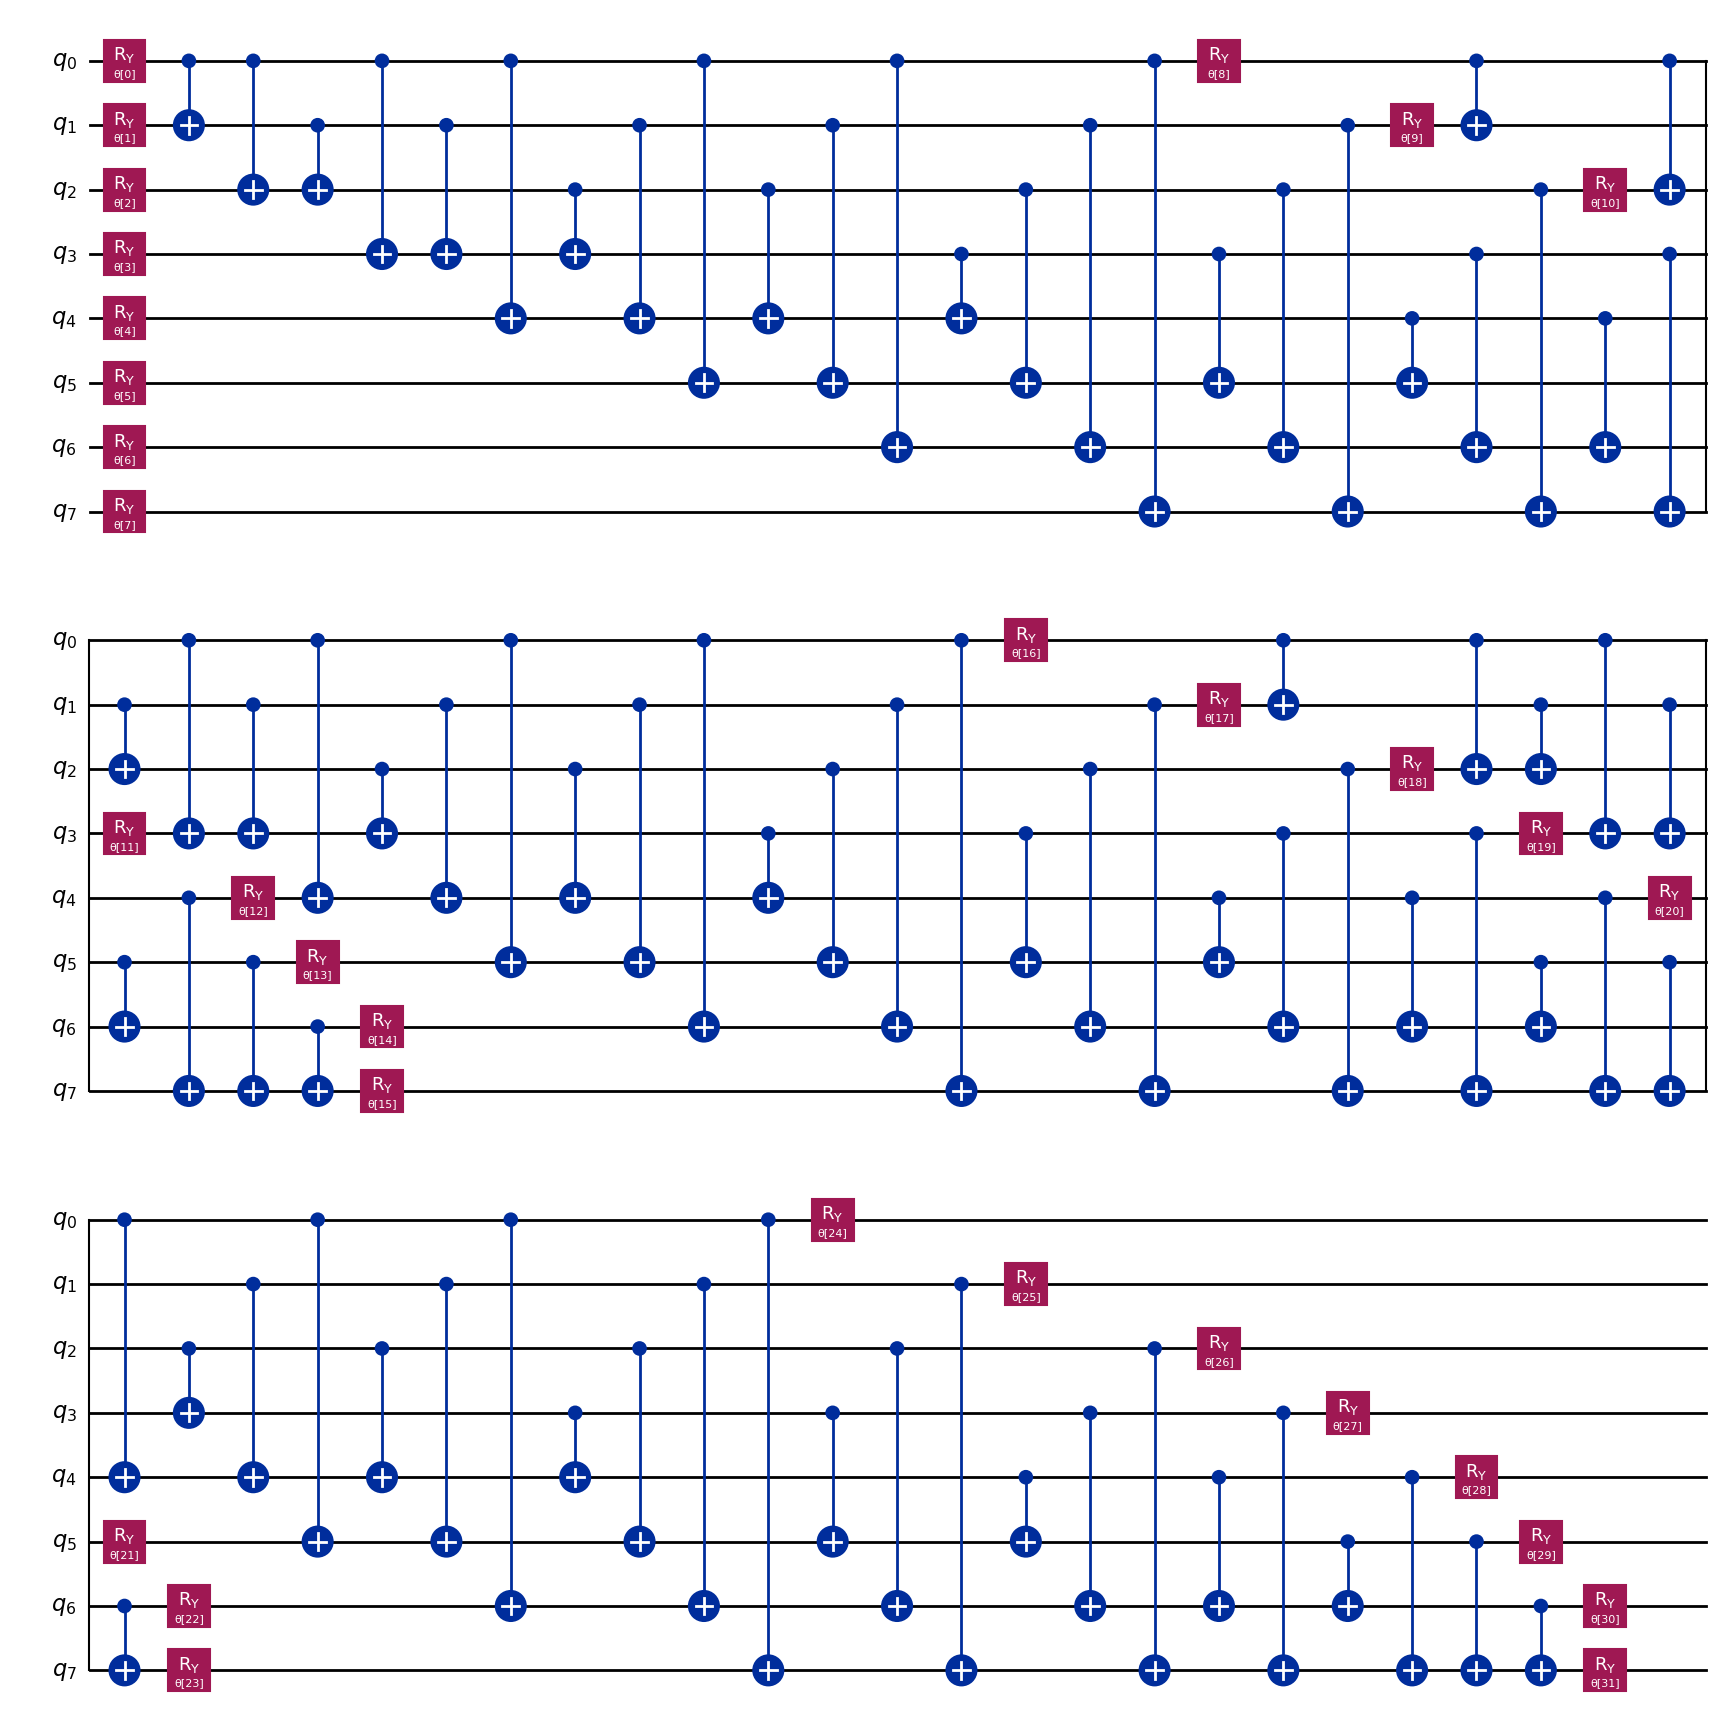

In [ ]:
ansatz.draw('mpl')

Note we defined the ansatz as 3 reps, and this is shown in the circuit drawing - one initial layer of Ry gates after the feature map, and then 3 more sets (or reps)

```python
n_keys
```
Helper function created to allow for consistent ordering of ansatz parameters, for reproducibility.

In [ ]:
def n_keys(text):
    return [int(c) if c.isdigit() else c.lower() for c in re.split('([0-9]+)', text)]

```python
get_composed_quantum_state
```

In [ ]:
# function to get quantum state
def get_composed_quantum_state(x, fm, ansatz):
    """
    Gets quantum state of a composed circuit for a given input x
    """
    # copy circuit
    qc = ansatz.copy()
    # compose
    composed_circuit = fm.compose(qc, inplace=False)
    
    # sorted params
    sorted_params = sorted(composed_circuit.parameters, key=lambda x: n_keys(x.name))
    
    # param dict
    params = dict(zip(sorted_params, x))
    
    # assign params to circuit
    assigned_circuit = composed_circuit.assign_parameters(params, inplace=False)
    
    # save statevector
    assigned_circuit.save_statevector()
    
    # run on statevector simulator
    result = backend.run(assigned_circuit).result()
    return result.get_statevector()

In [ ]:
# sample to explain
X_sample = X_train[150]

In [ ]:
# fix feature map to sample
fm_param_dict = dict(zip(feature_map.parameters, X_sample))
fixed_fm = feature_map.assign_parameters(fm_param_dict)

In [ ]:
# get trained model parameters (weights)
opt_params = vqc.fit_result.x

In [ ]:
# assign parameters to ansatz
bound_ansatz = ansatz.assign_parameters(dict(zip(ansatz.parameters, opt_params)))

In [ ]:
# compose the fixed feature map and bound ansatz
ref_circuit = fixed_fm.compose(bound_ansatz, inplace=False)
ref_circuit.save_statevector()

In [ ]:
# get reference state to use in state fidelity comparison
result = backend.run(ref_circuit).result()
ref_state = result.get_statevector()

```python
ansatz_model_out
```

In [ ]:
# function to get quantum state
def ansatz_model_out(params):
    """
    Define a 'model' for ansatz, as SHAP explainer requires a scalar output.
    """
    params = np.array(params)
    # if the input is a single sample (1D), convert to 2D.
    if params.ndim == 1:
        params = params.reshape(1, -1)
    
    pred_list = []
    
    for row in params:
        # copy ansatz
        new_ansatz = ansatz.copy()
        state = get_composed_quantum_state(row, fixed_fm, new_ansatz)
        fidelity = state_fidelity(state, ref_state)
        
        
        pred_list.append([fidelity])  # append as list so final shape is (n,1)
    
    return np.array(pred_list)

```python
ansatz_parameter_shap
```

In [ ]:
def ansatz_parameter_shap(opt_params, background_params, ansatz_params, feature_names=None):
    """
    Calculate SHAP for ansatz parameters to explain how they contribute to the quantum state
    """
    explainer = KernelExplainer(
        model=ansatz_model_out,
        data=background_params
    )
    
    shap_values = explainer.shap_values(opt_params.reshape(1, -1))
    
    single_exp = shap_values[0]
    if single_exp.ndim > 1:
        single_exp = single_exp.flatten()
    abs_values = np.abs(single_exp)
    total = np.sum(abs_values)
    normalised_values = single_exp / total if total > 0 else single_exp
    
    plt.figure(figsize=(10, 6))
        
    explanation = Explanation(
        values=normalised_values,
        base_values=explainer.expected_value,
        data=opt_params,
        feature_names=[str(param) for param in ansatz_params]
    )
    
    print(f"Expected Value: {explainer.expected_value}")
    waterfall(explanation, max_display=32, show=False)
    
    plt.title('Ansatz Parameter Importance (SHAP)')
    plt.tight_layout()
    plt.show()
    
    return shap_values

  0%|          | 0/1 [00:00<?, ?it/s]

Expected Value: [0.92689847]


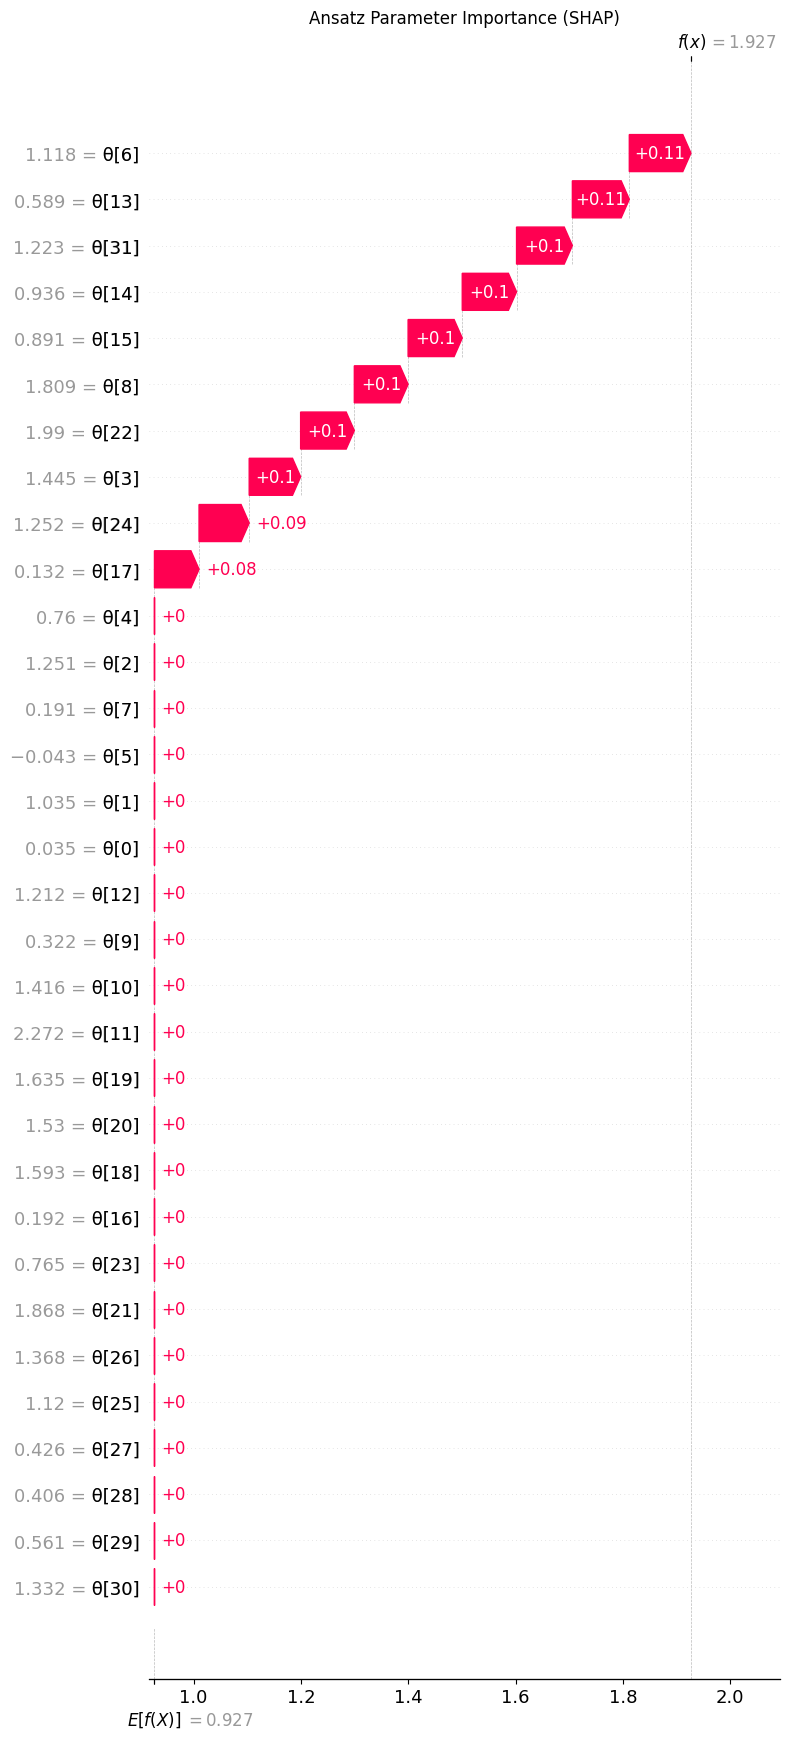

In [ ]:
num_background = 100
background_params = np.array([opt_params + np.random.normal(0, 0.1, size=opt_params.shape) for _ in range(num_background)])

shap_values = ansatz_parameter_shap(
    opt_params=opt_params,
    background_params=background_params,
    ansatz_params=ansatz.parameters,
    feature_names=None
)

In [ ]:
abs_vals = np.abs(shap_values[0])
total = np.sum(abs_vals)
normalised_values = shap_values[0] / total if total > 0 else shap_values[0]

In [ ]:
# get indexes of parameters for each layer
layer1_idx = np.arange(0, 7) # init layer after feature map
layer2_idx = np.arange(8, 15)
layer3_idx = np.arange(16, 23)
layer4_idx = np.arange(24, 31)

Absolute values used here, as direction doesn't matter, rather the magnitude of each layers importance. If np.abs wasn't used here, positive and negative values may end up cancelling each other out.

In [ ]:
# get shap values for each layer
layer1_importance = np.sum(np.abs(normalised_values[layer1_idx]))
layer2_importance = np.sum(np.abs(normalised_values[layer2_idx]))
layer3_importance = np.sum(np.abs(normalised_values[layer3_idx]))
layer4_importance = np.sum(np.abs(normalised_values[layer4_idx]))

In [ ]:
# create array of layer importances
layer_importances = np.array([layer1_importance, layer2_importance, layer3_importance, layer4_importance])

# list for layer names
layer_names = ['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3']

In [ ]:
# explanation object for layer importances
# no need for background data as we are aggregating already computed shap values
layer_explanation = Explanation(
    values=layer_importances,
    base_values=0,
    data=layer_importances,
    feature_names=layer_names
)

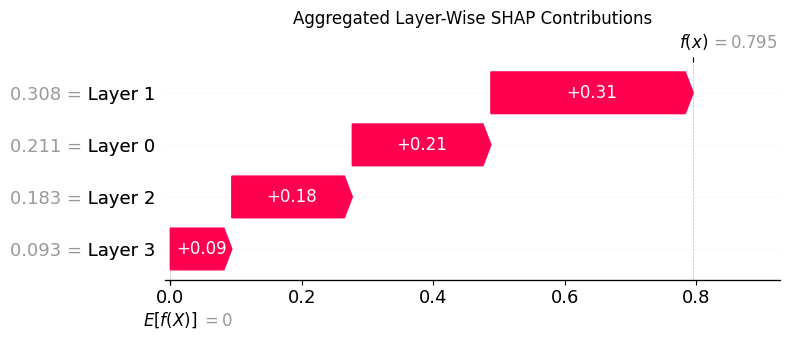

In [ ]:
# plot layer importances
waterfall(layer_explanation, max_display=len(layer_names), show=False)
plt.title('Aggregated Layer-Wise SHAP Contributions')
plt.tight_layout()
plt.show()